# Deep Learning Toolkit for Splunk - Rapids UMAP

This notebook contains an example workflow how to work on custom containerized code that seamlessly interfaces with the Deep Learning Toolkit for Splunk.

Note: By default every time you save this notebook the cells are exported into a python module which is then invoked by Splunk MLTK commands like <code> | fit ... | apply ... | summary </code>. Please read the Model Development Guide in the Deep Learning Toolkit app for more information.

## Stage 0 - import libraries
At stage 0 we define all imports necessary to run our subsequent code depending on various libraries.

In [49]:
# this definition exposes all python module imports that should be available in all subsequent commands
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datashader as ds
import datashader.transfer_functions as tf
import base64
import io 

import cudf
from cuml.manifold.umap import UMAP as cumlUMAP
# ...
# global constants
MODEL_DIRECTORY = "/srv/app/model/data/"

In [50]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
print("numpy version: " + np.__version__)
print("pandas version: " + pd.__version__)

numpy version: 1.18.1
pandas version: 0.25.3


## Stage 1 - get a data sample from Splunk
In Splunk run a search to pipe a dataset into your notebook environment. Note: mode=stage is used in the | fit command to do this.

| inputlookup dga_domains_features.csv</br>
| fit MLTKContainer algo=rapids_umap plot="datashader" class from ut* PC* into app:dga_rapids_umap


After you run this search your data set sample is available as a csv inside the container to develop your model. The name is taken from the into keyword ("barebone_model" in the example above) or set to "default" if no into keyword is present. This step is intended to work with a subset of your data to create your custom model.

In [94]:
# this cell is not executed from MLTK and should only be used for staging data into the notebook environment
def stage(name):
    with open("data/"+name+".csv", 'r') as f:
        df = pd.read_csv(f)
    with open("data/"+name+".json", 'r') as f:
        param = json.load(f)
    return df, param

In [95]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
df, param = stage("dga_rapids_umap")
print(df.describe())
print(param)

               PC_1          PC_2          PC_3  ut_consonant_ratio  \
count  1.000000e+05  1.000000e+05  1.000000e+05       100000.000000   
mean  -2.884804e-17  3.126388e-17  4.547474e-18            0.663744   
std    3.009696e-01  2.765589e-01  2.462737e-01            0.116289   
min   -6.329973e-01 -4.584987e-01 -4.336646e-01            0.157895   
25%   -2.302162e-01 -1.668878e-01 -9.667472e-02            0.600000   
50%    2.829823e-02 -7.662463e-02 -4.886632e-02            0.666667   
75%    1.429489e-01  1.020034e-01  4.465652e-02            0.714286   
max    7.522650e-01  8.231569e-01  8.860410e-01            1.000000   

       ut_digit_ratio  ut_domain_length  ut_meaning_ratio     ut_shannon  \
count   100000.000000     100000.000000     100000.000000  100000.000000   
mean         0.112564         21.387000          0.292602       3.690800   
std          0.132294          7.703738          0.213134       0.425123   
min          0.000000          1.000000          0.00000

In [96]:
param['feature_variables'] + param['target_variables']

['ut_consonant_ratio',
 'ut_digit_ratio',
 'ut_domain_length',
 'ut_meaning_ratio',
 'ut_shannon',
 'ut_vowel_ratio',
 'PC_1',
 'PC_2',
 'PC_3',
 'subclass']

## Stage 2 - create and initialize a model

In [97]:
# initialize your model
# available inputs: data and parameters
# returns the model object which will be used as a reference to call fit, apply and summary subsequently
def init(df,param):
    model = {}
    return model

In [98]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
model = init(df,param)
print(model)

{}


## Stage 3 - fit the model

In [99]:
# train your model
# returns a fit info json object and may modify the model object
def fit(model,df,param):
    # model.fit()
    info = {"message": "no fit needed"}
    return info

In [100]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
print(fit(model,df,param))

{'message': 'no fit needed'}


## Stage 4 - apply the model

In [101]:
# apply your model
# returns the calculated results
def plot_to_base64(plot):
    pic_IObytes = io.BytesIO()
    if hasattr(plot,'fig'):
        plot.fig.savefig(pic_IObytes, format='png')
    elif hasattr(plot,'figure'):
        plot.figure.savefig(pic_IObytes, format='png')
    pic_IObytes.seek(0)
    pic_hash = base64.b64encode(pic_IObytes.read())
    pic_IObytes.close()
    return pic_hash

def plot_datashader_as_base64(df,param):
    cat = param['target_variables'][0]
    dfr = df.astype({cat: 'category'})
    squ = 25.0
    dfr = dfr[dfr["UMAP1"].between(-squ, squ) & dfr["UMAP2"].between(-squ, squ)]
    cvs = ds.Canvas(plot_width=800, plot_height=600)
    agg = cvs.points(dfr, 'UMAP1', 'UMAP2', ds.count_cat(cat))
    color_key_dga = {'dga':'red', 'legit':'blue'}

    img = tf.shade(agg, cmap=color_key_dga, how="eq_hist")

    #img.plot()
    pic_IObytes = img.to_bytesio()
    pic_IObytes.seek(0)
    pic_hash = base64.b64encode(pic_IObytes.read())
    return str(pic_hash)


def plot_scatter_as_base64(df,param):
    hue=None
    if 'options' in param:
        if 'target_variable' in param['options']:
            hue=str(param['options']['target_variable'][0])
    #plot = sns.pairplot(df,hue=hue, palette="husl")
    sns.set()
    plot = sns.scatterplot(x="UMAP1", y="UMAP2", data=df)
    res = str(plot_to_base64(plot))
    return res

def apply(model,df,param):
    # param['options']['model_name']
    dfeatures = df[param['feature_variables']]
    cuml_umap = cumlUMAP()
    #model['umap'] = cuml_umap
    gdf = cudf.DataFrame.from_pandas(df)
    embedding = cuml_umap.fit_transform(gdf)
    result = embedding.rename(columns={0: "UMAP1", 1: "UMAP2"}).to_pandas()
    result_plot = df[param['target_variables']].join(result)
    if 'plot' in param['options']['params']:
        plots = param['options']['params']['plot'].lstrip("\"").rstrip("\"").lower().split(',')
        for plot in plots:
            if plot=='scatter':
                model["plot_scatter"] = plot_scatter_as_base64(result,param)
            elif plot=='datashader':
                model["plot_datashader"] = plot_datashader_as_base64(result_plot,param)
            else:
                continue

    return result_plot


,subclass,UMAP1,UMAP2
0,legit,-0.322556,5.951560
1,legit,-4.920866,-9.616891
2,legit,-6.091855,7.682178
3,legit,-4.102695,11.969825
4,legit,-6.599295,-10.787489
...,...,...,...
99995,locky,3.982634,3.999881
99996,locky,-7.426095,7.203380
99997,locky,1.505907,-2.775162
99998,locky,-1.021333,-2.848526


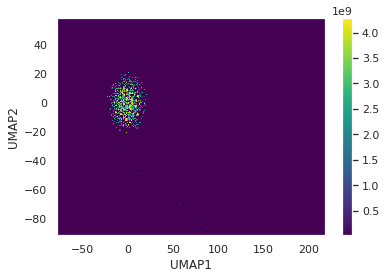

In [102]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
result = apply(model,df,param)
result

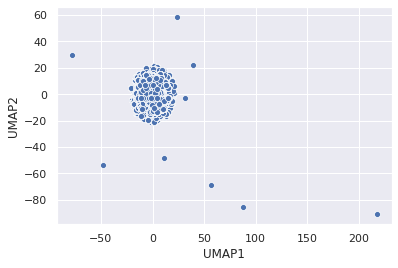

In [103]:
plot = sns.scatterplot(x="UMAP1", y="UMAP2", data=result)
plot


## Stage 5 - save the model

In [104]:
# save model to name in expected convention "<algo_name>_<model_name>"
def save(model,name):
    with open(MODEL_DIRECTORY + name + ".json", 'w') as file:
        json.dump(model, file)
    return model

In [109]:
model  = save(model,'umap_dga')

## Stage 6 - load the model

In [110]:
# load model from name in expected convention "<algo_name>_<model_name>"
def load(name):
    model = {}
    with open(MODEL_DIRECTORY + name + ".json", 'r') as file:
        model = json.load(file)
    return model

In [111]:
model = load('umap_dga')

## Stage 7 - provide a summary of the model

In [112]:
# return a model summary
def summary(model=None):
    returns = {"version": {"numpy": np.__version__, "pandas": pd.__version__} }
    return returns

## End of Stages
All subsequent cells are not tagged and can be used for further freeform code

In [15]:
print(summary(model))

{'version': {'numpy': '1.18.1', 'pandas': '0.25.3'}}
